
# Tarea N°02
## Instrucciones
1.- Completa tus datos personales (nombre y rol USM) en siguiente celda.

**Nombre**: Pablo Calcumil Alarcón

**Rol**: 201673563-1

2.- Debes pushear este archivo con tus cambios a tu repositorio personal del curso, incluyendo datos, imágenes, scripts, etc.

3.- Se evaluará:

- Soluciones
- Código
- Que Binder esté bien configurado.
- Al presionar  `Kernel -> Restart Kernel and Run All Cells` deben ejecutarse todas las celdas sin error.

## I.- Clasificación de dígitos


En este laboratorio realizaremos el trabajo de reconocer un dígito a partir de una imagen.


![rgb](https://www.wolfram.com/language/11/neural-networks/assets.en/digit-classification/smallthumb_1.png)

El objetivo es a partir de los datos, hacer la mejor predicción de cada imagen. Para ellos es necesario realizar los pasos clásicos de un proyecto de _Machine Learning_, como estadística descriptiva, visualización y preprocesamiento. 

* Se solicita ajustar al menos tres modelos de clasificación:
 * Regresión logística
 * K-Nearest Neighbours 
 * Uno o más algoritmos a su elección [link](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) (es obligación escoger un _estimator_ que tenga por lo menos un hiperparámetro). 
 
 
* En los modelos que posean hiperparámetros es mandatorio buscar el/los mejores con alguna técnica disponible en `scikit-learn` ([ver más](https://scikit-learn.org/stable/modules/grid_search.html#tuning-the-hyper-parameters-of-an-estimator)).
* Para cada modelo, se debe realizar _Cross Validation_ con 10 _folds_ utilizando los datos de entrenamiento con tal de determinar un intervalo de confianza para el _score_ del modelo.
* Realizar una predicción con cada uno de los tres modelos con los datos _test_ y obtener el _score_. 
* Analizar sus métricas de error (**accuracy**, **precision**, **recall**, **f-score**)



### Exploración de los datos
A continuación se carga el conjunto de datos a utilizar, a través del sub-módulo `datasets` de `sklearn`.

In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
digits_dict = datasets.load_digits()
print(digits_dict["DESCR"])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [3]:
digits_dict.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

In [4]:
digits_dict["target"]

array([0, 1, 2, ..., 8, 9, 8])

A continuación se crea dataframe declarado como `digits` con los datos de `digits_dict` tal que tenga 65 columnas, las 6 primeras a la representación de la imagen en escala de grises (0-blanco, 255-negro) y la última correspondiente al dígito (`target`) con el nombre _target_.

In [5]:
digits = (
    pd.DataFrame(
        digits_dict["data"],
    )
    .rename(columns=lambda x: f"c{x:02d}")
    .assign(target=digits_dict["target"])
    .astype(int)
)

digits.head()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


### Ejercicio 1
**Análisis exploratorio:** Realiza tu análisis exploratorio, no debes olvidar nada! Recuerda, cada análisis debe responder una pregunta.

Algunas sugerencias:

* ¿Cómo se distribuyen los datos?
* ¿Cuánta memoria estoy utilizando?
* ¿Qué tipo de datos son?
* ¿Cuántos registros por clase hay?
* ¿Hay registros que no se correspondan con tu conocimiento previo de los datos?

Primero se verá de que tipo de datos son:

In [6]:
digits.dtypes

c00       int64
c01       int64
c02       int64
c03       int64
c04       int64
          ...  
c60       int64
c61       int64
c62       int64
c63       int64
target    int64
Length: 65, dtype: object

In [7]:
if True not in digits.isnull().any().values:
    print('No hay datos nulos en ninguna columna')

No hay datos nulos en ninguna columna


Ahora, se verán los valores que hay en cada columna en el siguiente Dataframe, por ejemplo, en la columna c00 solo se encuentra el valor 0, y en c01 esta el 0, 2, 5, 1, 6, 3, 4, 7 y 8, mientras que los valores NaN son para dimensionar de forma correcta el dataframe.

In [8]:
#Lista con los valores unicos en cada columna
list_val_cols = [list(digits[column].unique()) for column in digits.columns]
dict_df = {}

#Maximo largo de un arreglo de valores en la lista
max_len = max([len(i) for i in list_val_cols])

#Se dejan todos los arreglos en la lista con el mismo largo y se agrega a un dict
for i in range(0, len(digits.columns)):
    if len(list_val_cols[i]) != max_len:
        for j in range(len(list_val_cols[i]), max_len):
            list_val_cols[i].append(None)
    dict_df[digits.columns[i]] = list_val_cols[i]

#Con el dict se forma el DataFrame
df = pd.DataFrame(dict_df)
df

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
0,0.0,0.0,5,13,9,1,0,0.0,0.0,0,...,0.0,0.0,0.0,6,13,10,0,0,0,0.0
1,NaN,2.0,0,12,13,5,15,1.0,1.0,8,...,2.0,1.0,2.0,0,11,16,10,9,4,1.0
2,NaN,5.0,7,4,15,12,1,10.0,2.0,2,...,4.0,NaN,4.0,7,3,11,16,3,1,2.0
3,NaN,1.0,12,15,11,0,3,11.0,NaN,4,...,1.0,NaN,1.0,9,2,13,9,1,2,3.0
4,NaN,6.0,9,1,0,16,2,2.0,NaN,11,...,3.0,NaN,3.0,1,16,15,4,12,6,4.0
5,NaN,3.0,11,10,8,11,4,7.0,NaN,3,...,6.0,NaN,5.0,13,9,0,11,11,5,5.0
6,NaN,4.0,1,8,14,13,11,3.0,NaN,1,...,5.0,NaN,9.0,11,5,8,3,4,15,6.0
7,NaN,7.0,10,14,1,9,5,6.0,NaN,5,...,8.0,NaN,6.0,3,12,2,13,13,7,7.0
8,NaN,8.0,6,9,16,10,6,13.0,NaN,7,...,9.0,NaN,8.0,12,10,9,15,7,12,8.0
9,NaN,NaN,3,0,4,7,8,5.0,NaN,6,...,10.0,NaN,7.0,15,1,5,12,5,10,9.0


Ahora, se verá la cantidad de datos que se tiene para cada valor en `target`:

In [9]:
for i in range(0, len(digits.target.value_counts())):
    print('El valor en target', digits.target.value_counts().index[i] 
          ,'tiene la siguiente frecuencia:', digits.target.value_counts().values[i])

El valor en target 3 tiene la siguiente frecuencia: 183
El valor en target 5 tiene la siguiente frecuencia: 182
El valor en target 1 tiene la siguiente frecuencia: 182
El valor en target 6 tiene la siguiente frecuencia: 181
El valor en target 4 tiene la siguiente frecuencia: 181
El valor en target 9 tiene la siguiente frecuencia: 180
El valor en target 7 tiene la siguiente frecuencia: 179
El valor en target 0 tiene la siguiente frecuencia: 178
El valor en target 2 tiene la siguiente frecuencia: 177
El valor en target 8 tiene la siguiente frecuencia: 174


Con esto se puede ver que el que tiene mayor frecuencia es 3 y menor frecuencia es 8.

Esto se puede ver, a través del siguiente histograma:

In [10]:
def annotate(**kwargs):
    g=plt.gca()
    for p in g.patches:
        g.annotate(format(p.get_height(), ',.1f'),
                   ((p.get_x() + p.get_width() / 2.) ,p.get_height()),
                   ha = 'center', va = 'center', xytext = (0, 10),
                   textcoords = 'offset points')

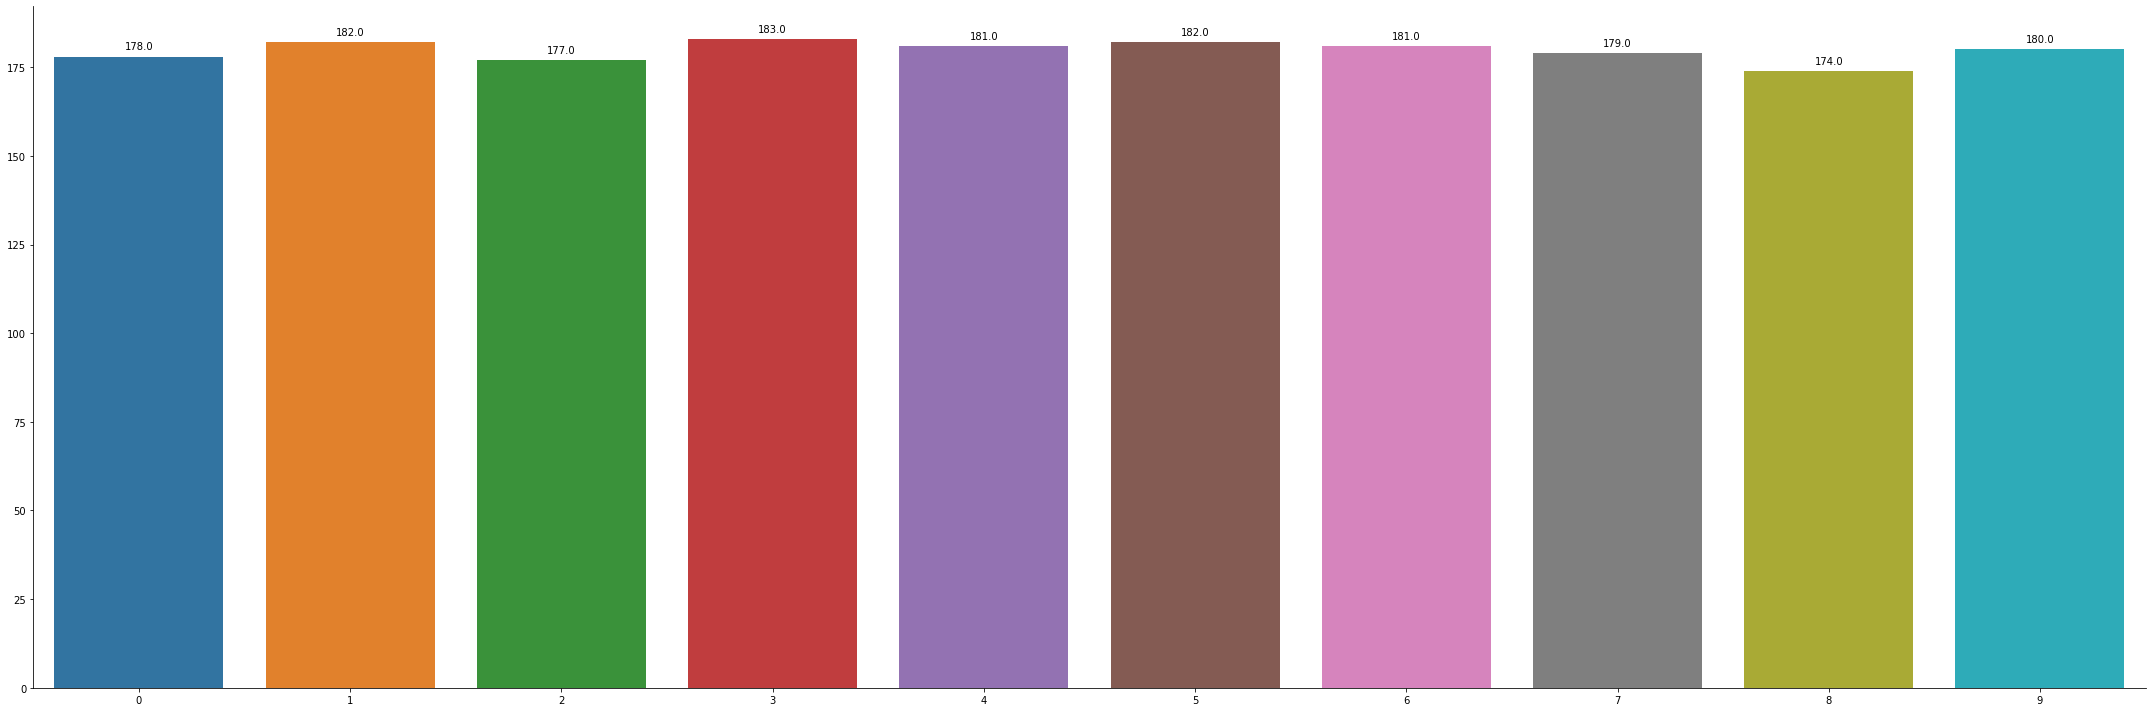

In [11]:
g = sns.catplot(x = 'target',
                data = digits, 
                kind = 'count',
                height = 10,
                aspect = 3)
g.map(annotate)
sns.set_context('talk')

In [12]:
print('La media de los valores en target es:',
        round(sum(digits.target.value_counts().index[i] * digits.target.value_counts().values[i]
              for i in range(0, len(digits.target.value_counts()))) / sum(digits.target.value_counts()),2))

La media de los valores en target es: 4.49


### Ejercicio 2
**Visualización:** Para visualizar los datos utilizaremos el método `imshow` de `matplotlib`. Resulta necesario convertir el arreglo desde las dimensiones (1,64)  a (8,8) para que la imagen sea cuadrada y pueda distinguirse el dígito. Superpondremos además el label correspondiente al dígito, mediante el método `text`. Esto nos permitirá comparar la imagen generada con la etiqueta asociada a los valores. Realizaremos lo anterior para los primeros 25 datos del archivo.

In [13]:
digits_dict["images"][0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Visualiza imágenes de los dígitos utilizando la llave `images` de `digits_dict`. 

Sugerencia: Utiliza `plt.subplots` y el método `imshow`. Puedes hacer una grilla de varias imágenes al mismo tiempo!

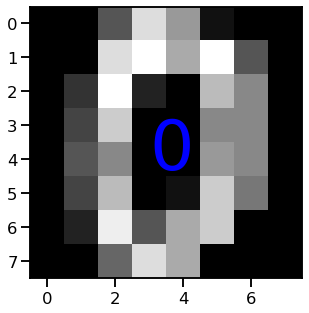

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

#Se excribe superpuesto el numero, en el numero a reconocer con imshow
ax.text(3 , 4.3 , str(0), fontsize = 70, color = 'b')
ax.imshow(digits_dict["images"][0], cmap = 'gray' )

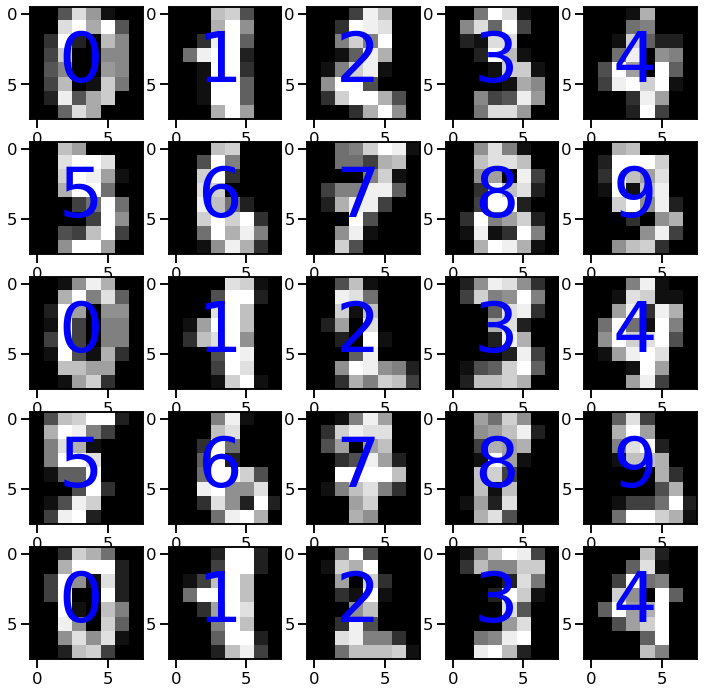

In [15]:
nx, ny = 5, 5
fig, axs = plt.subplots(nx, ny, figsize=(12, 12))

#Print los subplots y superpuesto el numero
for i in range(0, nx):
    for j in range(0, ny):
        axs[i, j].text(1.5 , 4.8 , str((5 * i + j) % 10 ), fontsize = 70, color = 'b')
        axs[i, j].imshow(digits_dict["images"][5 * i + j], cmap = 'gray' )

### Ejercicio 3

**Machine Learning**: En esta parte usted debe entrenar los distintos modelos escogidos desde la librería de `sklearn`. Para cada modelo, debe realizar los siguientes pasos:

* **train-test** 
 * Crear conjunto de entrenamiento y testeo (usted determine las proporciones adecuadas).
 * Imprimir por pantalla el largo del conjunto de entrenamiento y de testeo.
 
 
* **modelo**:
 * Instanciar el modelo objetivo desde la librería sklearn.
 * *Hiper-parámetros*: Utiliza `sklearn.model_selection.GridSearchCV` para obtener la mejor estimación de los parámetros del modelo objetivo.




* **Métricas**:
 * Graficar matriz de confusión.
 * Analizar métricas de error.



__Preguntas a responder:__

* ¿Cuál modelo es mejor basado en sus métricas?
* ¿Cuál modelo demora menos tiempo en ajustarse?
* ¿Qué modelo escoges?


In [16]:
X = digits.drop(columns = "target").values
y = digits["target"].values

In [17]:
X

array([[ 0,  0,  5, ...,  0,  0,  0],
       [ 0,  0,  0, ..., 10,  0,  0],
       [ 0,  0,  0, ..., 16,  9,  0],
       ...,
       [ 0,  0,  1, ...,  6,  0,  0],
       [ 0,  0,  2, ..., 12,  0,  0],
       [ 0,  0, 10, ..., 12,  1,  0]])

In [18]:
y

array([0, 1, 2, ..., 8, 9, 8])

Se toma el 15% de los datos, como datos de test.

In [19]:
from sklearn.model_selection import train_test_split

#Conjunto de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.18, random_state = 42)
print('Los datos de train en total son:', len(X_train))
print('Los datos de test en total son:',len(X_test))

Los datos de train en total son: 1473
Los datos de test en total son: 324


In [20]:
#Regresion Logistica
from metrics_classification import *
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression

#KNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn import preprocessing

#Tree Classifier
from sklearn.tree import DecisionTreeClassifier

#Matriz de Confusion
from sklearn.metrics import confusion_matrix

### Regresion logistica

In [21]:
#Iniciar modelo
reg_log = LogisticRegression(max_iter = 5000)

#Entrenar
reg_log.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
#Metricas
metrics_reg_log = summary_metrics(pd.DataFrame({'y': y_test, 'yhat': reg_log.predict(X_test)}))
metrics_reg_log

,accuracy,recall,precision,fscore
0,0.9753,0.9756,0.977,0.9761


In [23]:
#Matriz de Confusion
matrix_conf = confusion_matrix(list(y_test),list(reg_log.predict(X_test)))
matrix_conf

array([[30,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 26,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 31,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 31,  0,  1,  0,  0,  0,  0],
       [ 0,  1,  0,  0, 42,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 41,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  1, 32,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0, 27,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0, 21,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  1, 35]])

In [24]:
print('Se acertó en:',sum(y_test == reg_log.predict(X_test)) ,'datos.')

Se acertó en: 316 datos.


In [25]:
def count_fp_fn(matrix):
    
    #Lista de la suma de valores en la parte triangular superior
    list_false_positive = [sum(matrix_conf.T[i][i + 1:]) for i in range(0,matrix_conf.shape[0] - 1) 
                                                       if sum(matrix_conf.T[i][i + 1:]) != 0]
    
    #Lista de la suma de valores en la parte triangular inferior
    list_false_negative = [sum(matrix_conf[i][i + 1:]) for i in range(0,matrix_conf.shape[0] - 1) 
                                                       if sum(matrix_conf[i][i + 1:]) != 0]
    count_fp = sum(list_false_positive)
    count_fn = sum(list_false_negative)
    return (count_fp, count_fn)

In [26]:
#Contaremos los falsos positivos y los falsos negativos
falses_pos_neg = count_fp_fn(matrix_conf)

print('Se tiene que los falsos positivos en este caso son:', falses_pos_neg[0])
print('Se tiene que los falsos negativos en este caso son:', falses_pos_neg[1])

Se tiene que los falsos positivos en este caso son: 6
Se tiene que los falsos negativos en este caso son: 2


### K NearestNeighbors

In [27]:
#Iniciar modelo
KNN = neighbors.KNeighborsClassifier()

#Entrenar
KNN.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [28]:
#Metricas
metrics_KNN = summary_metrics(pd.DataFrame({'y':y_test, 'yhat':KNN.predict(X_test)}))
metrics_KNN

,accuracy,recall,precision,fscore
0,0.9877,0.9886,0.9899,0.9892


In [29]:
#Matriz de Confusion
matrix_conf = confusion_matrix(list(y_test), list(KNN.predict(X_test)))
matrix_conf

array([[30,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 26,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 31,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 32,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 43,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 41,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0, 33,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 27,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 22,  0],
       [ 0,  0,  0,  0,  1,  1,  0,  0,  0, 35]])

In [30]:
print('Se acertó en:',sum(y_test == KNN.predict(X_test)) ,'datos.')

Se acertó en: 320 datos.


In [31]:
#Contaremos los falsos positivos y los falsos negativos
falses_pos_neg = count_fp_fn(matrix_conf)

print('Se tiene que los falsos positivos en este caso son:', falses_pos_neg[0])
print('Se tiene que los falsos negativos en este caso son:', falses_pos_neg[1])

Se tiene que los falsos positivos en este caso son: 2
Se tiene que los falsos negativos en este caso son: 2


### Arbol de Decision

In [32]:
#Iniciar modelo
tree_dec = DecisionTreeClassifier(max_depth = 10)

#Entrenar
tree_dec.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [33]:
#Metricas
metrics_tree_dec = summary_metrics(pd.DataFrame({'y': y_test, 'yhat': tree_dec.predict(X_test)}))
metrics_tree_dec

,accuracy,recall,precision,fscore
0,0.8704,0.8631,0.8652,0.8628


In [34]:
#Matriz de Confusion
matrix_conf = confusion_matrix(list(y_test),list(tree_dec.predict(X_test)))
matrix_conf

array([[27,  0,  0,  0,  1,  1,  0,  0,  1,  0],
       [ 0, 20,  2,  1,  1,  0,  0,  0,  1,  1],
       [ 0,  1, 22,  2,  0,  1,  1,  2,  2,  0],
       [ 0,  0,  1, 28,  0,  0,  1,  0,  1,  1],
       [ 0,  1,  0,  0, 39,  1,  1,  1,  0,  0],
       [ 0,  1,  1,  0,  0, 39,  0,  0,  0,  1],
       [ 1,  0,  0,  0,  1,  0, 31,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0, 27,  0,  0],
       [ 0,  1,  0,  2,  0,  0,  0,  0, 17,  2],
       [ 0,  1,  0,  3,  1,  0,  0,  0,  0, 32]])

In [35]:
print('Se acertó en:',sum(y_test == tree_dec.predict(X_test)) ,'datos.')

Se acertó en: 282 datos.


In [36]:
#Contaremos los falsos positivos y los falsos negativos
falses_pos_neg = count_fp_fn(matrix_conf)

print('Se tiene que los falsos positivos en este caso son:', falses_pos_neg[0])
print('Se tiene que los falsos negativos en este caso son:', falses_pos_neg[1])

Se tiene que los falsos positivos en este caso son: 16
Se tiene que los falsos negativos en este caso son: 26


In [37]:
metrics_reg_log.loc[1] = metrics_KNN.loc[0]
metrics_reg_log.loc[2] = metrics_tree_dec.loc[0]
metrics_reg_log['model'] = ['reg_log', 'knn', 'tree_dec']
metrics = metrics_reg_log.set_index('model')
metrics

,accuracy,recall,precision,fscore
model,,,,
reg_log,0.9753,0.9756,0.9770,0.9761
knn,0.9877,0.9886,0.9899,0.9892
tree_dec,0.8704,0.8631,0.8652,0.8628


In [38]:
metrics.loc[metrics['fscore'] == max(metrics['fscore'])]

,accuracy,recall,precision,fscore
model,,,,
knn,0.9877,0.9886,0.9899,0.9892


Luego, se puede ver que todos los modelos son bastante acertados, pero el que sobre sale es el `knn`, el cual no solo tiene el mejor `fscore`, sino que tiene los mejores valores en todas las metricas.

### Gridsearch

In [39]:
from sklearn.model_selection import GridSearchCV

#
model = DecisionTreeClassifier()

# rango de parametros
rango_criterion = ['gini','entropy']
rango_max_depth = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150])
param_grid = dict(criterion = rango_criterion, max_depth = rango_max_depth)
param_grid

{'criterion': ['gini', 'entropy'],
 'max_depth': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  15,
         20,  30,  40,  50,  70,  90, 120, 150])}

In [40]:
gs = GridSearchCV(estimator = model, 
                  param_grid = param_grid,
                  scoring = 'accuracy',
                  cv = 10,
                  n_jobs = -1)

gs = gs.fit(X_train, y_train)

In [41]:
# imprimir resultados
gs.best_score_

0.859441073726788

In [42]:
gs.best_params_

{'criterion': 'entropy', 'max_depth': 12}

### Ejercicio 4

__Comprensión del modelo:__ Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, debe comprender e interpretar minuciosamente los resultados y gráficos asociados al modelo en estudio, para ello debe resolver los siguientes puntos:



 * **Cross validation**: usando **cv** (con n_fold = 10), sacar una especie de "intervalo de confianza" sobre alguna de las métricas estudiadas en clases: 
  * $\mu \pm \sigma$ = promedio $\pm$ desviación estandar
 * **Curva de Validación**: Replica el ejemplo del siguiente [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.
 * **Curva AUC–ROC**: Replica el ejemplo del siguiente  [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.

In [43]:
#Cross validation

from sklearn.model_selection import cross_val_score

#Validation curve
from sklearn.model_selection import validation_curve

# AUC-ROC curve
from sklearn.metrics import roc_curve, auc

In [44]:
#Modelo
model = KNeighborsClassifier()
#Cross Validation
precision = cross_val_score(estimator = model, 
                            X = X_train,
                            y = y_train,
                            cv = 10)
#Media y Desviacion estandar
media_model = precision.mean()
std_model = precision.std()
print('El intervalo de confianza es: (', (media_model - std_model).round(4),
     ', ',(media_model + std_model).round(4), ').')

El intervalo de confianza es: ( 0.9759 ,  0.9956 ).


In [45]:
KNN.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

/home/pablo/anaconda3/envs/mat281/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Unrecognized location 'Best'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


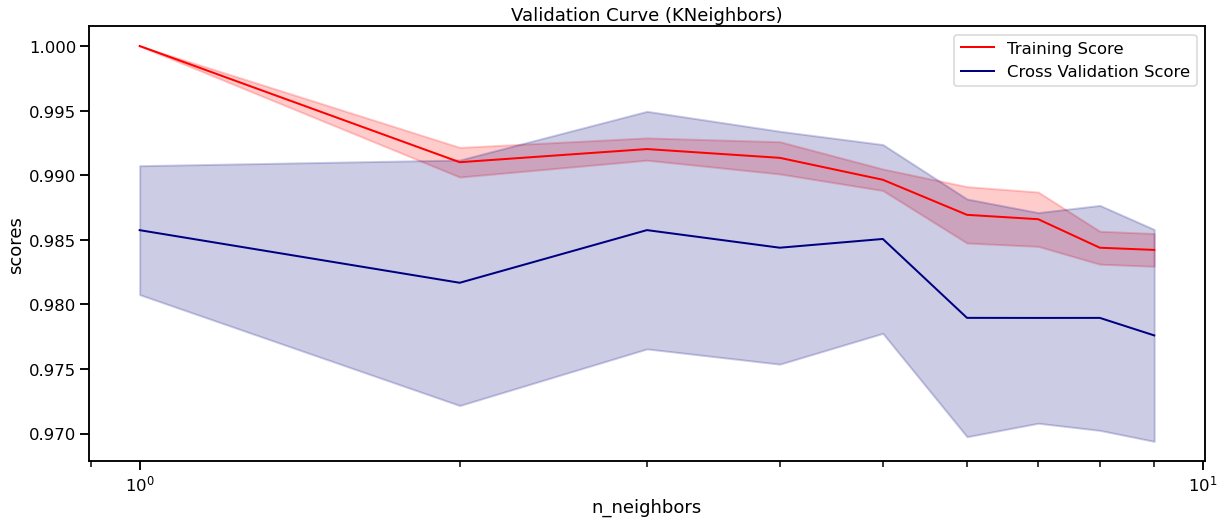

In [46]:
parameters = np.arange(1,10)
train_scores, test_scores = validation_curve(model,
                                             X_train,
                                             y_train,
                                             param_name = 'n_neighbors',
                                             param_range = parameters,
                                             scoring = 'accuracy',
                                             n_jobs = -1)
train_scores_mean = np.mean(train_scores, axis = 1)
train_scores_std = np.std(train_scores, axis = 1)
test_scores_mean = np.mean(test_scores, axis = 1)
test_scores_std = np.std(test_scores, axis = 1)

plt.figure(figsize=(20,8))
plt.title('Validation Curve (KNeighbors)')
plt.xlabel('n_neighbors')
plt.ylabel('scores')

#Train
plt.semilogx(parameters,
             train_scores_mean,
             label = 'Training Score',
             color = 'red',
             lw =2)
plt.fill_between(parameters,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 alpha = 0.2,
                 color = 'red',
                 lw = 2)

#Test
plt.semilogx(parameters,
             test_scores_mean,
             label = 'Cross Validation Score',
             color = 'navy',
             lw =2)
plt.fill_between(parameters,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha = 0.2,
                 color = 'navy',
                 lw = 2)

plt.legend(loc = 'Best')
plt.show()

### Ejercicio 5
__Reducción de la dimensión:__ Tomando en cuenta el mejor modelo encontrado en el `Ejercicio 3`, debe realizar una reducción de dimensionalidad del conjunto de datos. Para ello debe abordar el problema ocupando los dos criterios visto en clases:  

* **Selección de atributos**
* **Extracción de atributos**

__Preguntas a responder:__

Una vez realizado la reducción de dimensionalidad, debe sacar algunas estadísticas y gráficas comparativas entre el conjunto de datos original y el nuevo conjunto de datos (tamaño del dataset, tiempo de ejecución del modelo, etc.)


In [47]:
#Se escogera por medio de prueba chi cuadrado

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [48]:
data_X = pd.DataFrame(X)
data_X.columns = [f'c{k}' for k in range(0,X.shape[1])]
data_X['target']=y
data_X.head()

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


In [49]:
#Conjuntos de entrenamiento

X_train = data_X.drop(['target',], axis=1)
y_train = data_X['target']

In [50]:
# Aplicando prueba de Chi2

cols = list(X_train.columns.values)
select = SelectKBest(chi2, k = 45).fit(X_train, y_train) #Se seleccionan 45 elementos
for selects in list(select.get_support().nonzero()[0]):
    print(f'c{selects}')

c1
c2
c5
c6
c7
c9
c10
c12
c13
c14
c17
c18
c19
c20
c21
c22
c25
c26
c27
c28
c29
c30
c33
c34
c35
c36
c37
c38
c41
c42
c43
c44
c45
c46
c50
c51
c52
c53
c54
c57
c58
c60
c61
c62
c63


In [51]:
data_X = data_X[[cols[i] for i in list(select.get_support().nonzero()[0])]]
data_X.shape

(1797, 45)

Con esto ya está reducida la dimensión del data.

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [53]:
transform = StandardScaler().fit_transform(data_X)

#Dataframe normalizado
df_normalizado = pd.DataFrame(transform, columns = data_X.columns)
df_normalizado.head()

,c1,c2,c5,c6,c7,c9,c10,c12,c13,c14,...,c51,c52,c53,c54,c57,c58,c60,c61,c62,c63
0,-0.335016,-0.043081,-0.844129,-0.409724,-0.125023,-0.624009,0.482974,-0.058426,1.127721,0.879583,...,-0.868671,0.110130,0.537611,-0.757436,-0.299081,0.086719,-0.366771,-1.146647,-0.505670,-0.196008
1,-0.335016,-1.094937,-0.138020,-0.409724,-0.125023,-0.624009,-1.915573,1.196450,0.136195,-0.514991,...,1.236394,1.242083,-0.457500,-0.757436,-0.299081,-1.089383,0.849632,0.548561,-0.505670,-0.196008
2,-0.335016,-1.094937,1.097673,-0.409724,-0.125023,-0.624009,-1.362062,0.987304,0.962467,-0.514991,...,1.236394,1.242083,0.371759,0.259230,-0.299081,-1.089383,-0.164037,1.565686,1.695137,-0.196008
3,-0.335016,0.377661,-0.844129,-0.409724,-0.125023,1.879691,0.482974,0.987304,-0.690077,-0.514991,...,-1.060040,-0.833165,0.869315,1.072563,-0.299081,0.282736,0.241430,0.379040,-0.505670,-0.196008
4,-0.335016,-1.094937,-1.020657,-0.409724,-0.125023,-0.624009,-1.915573,-0.476718,-1.351095,-0.514991,...,-1.251410,1.053424,0.205907,-0.757436,-0.299081,-1.089383,0.849632,-0.468564,-0.505670,-0.196008


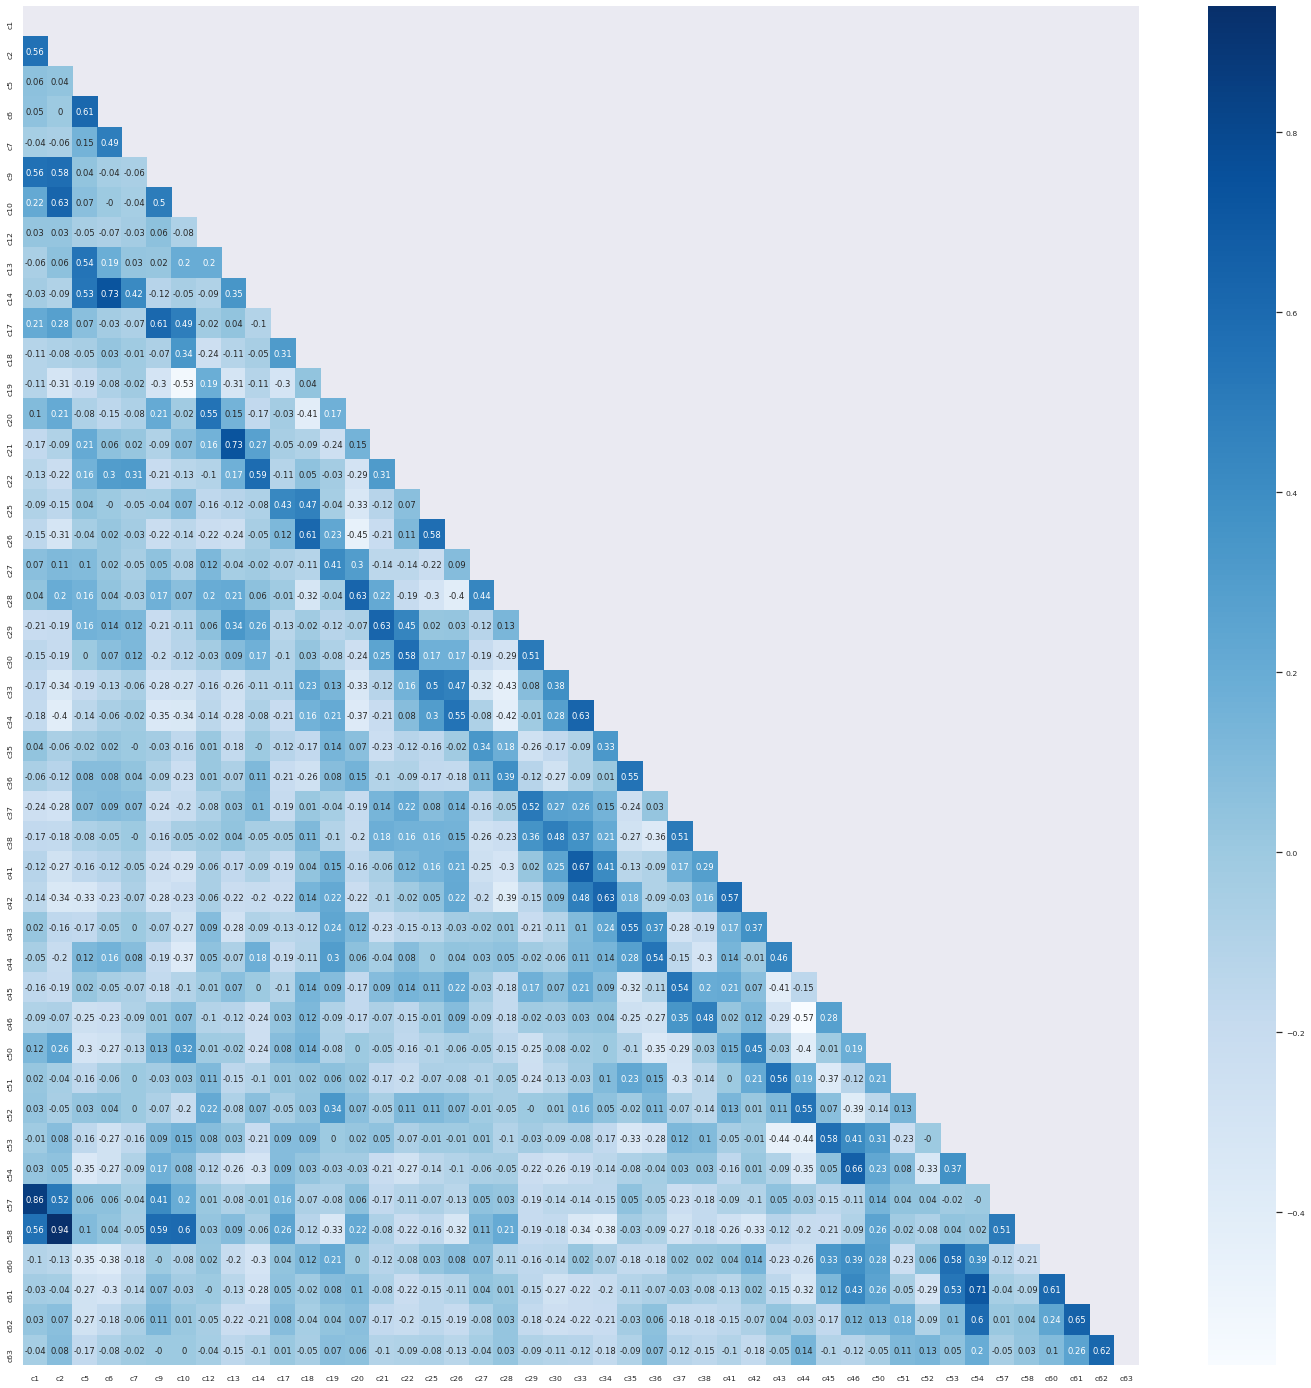

In [54]:
fig = plt.figure(figsize = (25,25))
sns.set(font_scale=0.7)
mask = np.triu(np.ones_like(df_normalizado.corr(), dtype = bool))

sns.heatmap(df_normalizado.corr().round(2), #Redondeo
            mask = mask,
            annot = True, fmt = 'g',        #Valores
            cmap = 'Blues')                 #Color
plt.show()

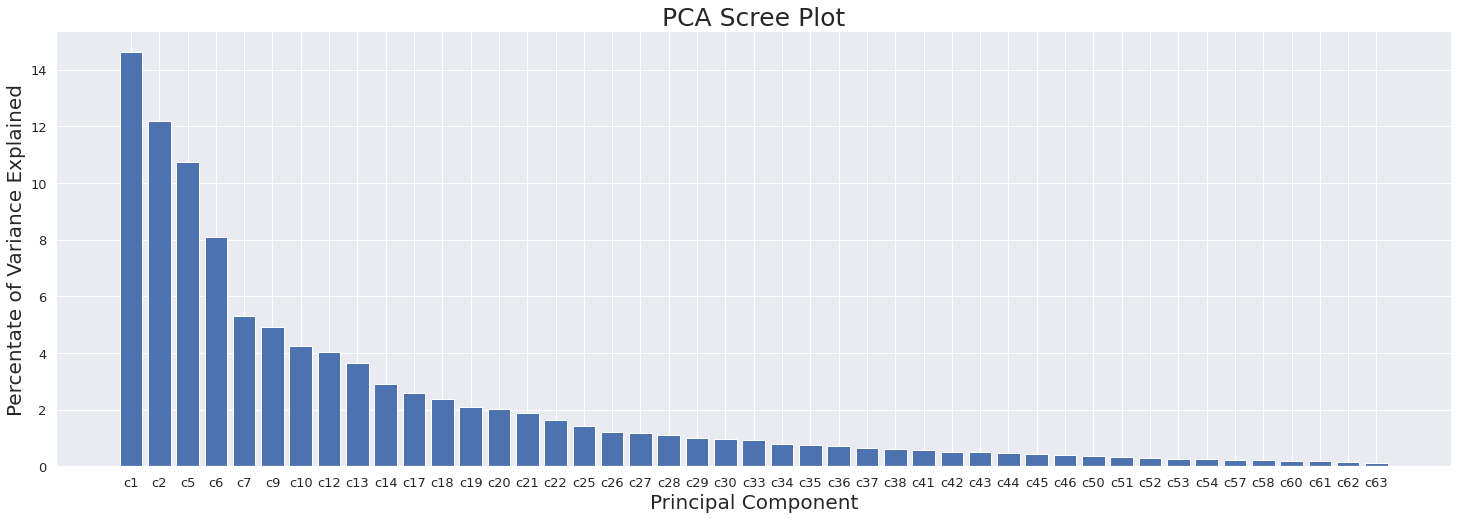

In [55]:
#PCA
pca = PCA(data_X.shape[1])
principalComponents = pca.fit_transform(transform)

varianzas = np.round(pca.explained_variance_ratio_ * 100, decimals = 2)
columns = df_normalizado.columns

plt.figure(figsize=(25,8))
plt.bar(x = range(0, len(columns)),
        height = varianzas,
        tick_label = columns)

plt.tick_params(labelsize = 13)
plt.ylabel('Percentate of Variance Explained', **{'size':'20'})
plt.xlabel('Principal Component', **{'size':'20'})
plt.title('PCA Scree Plot', **{'size': '25'})
plt.show()

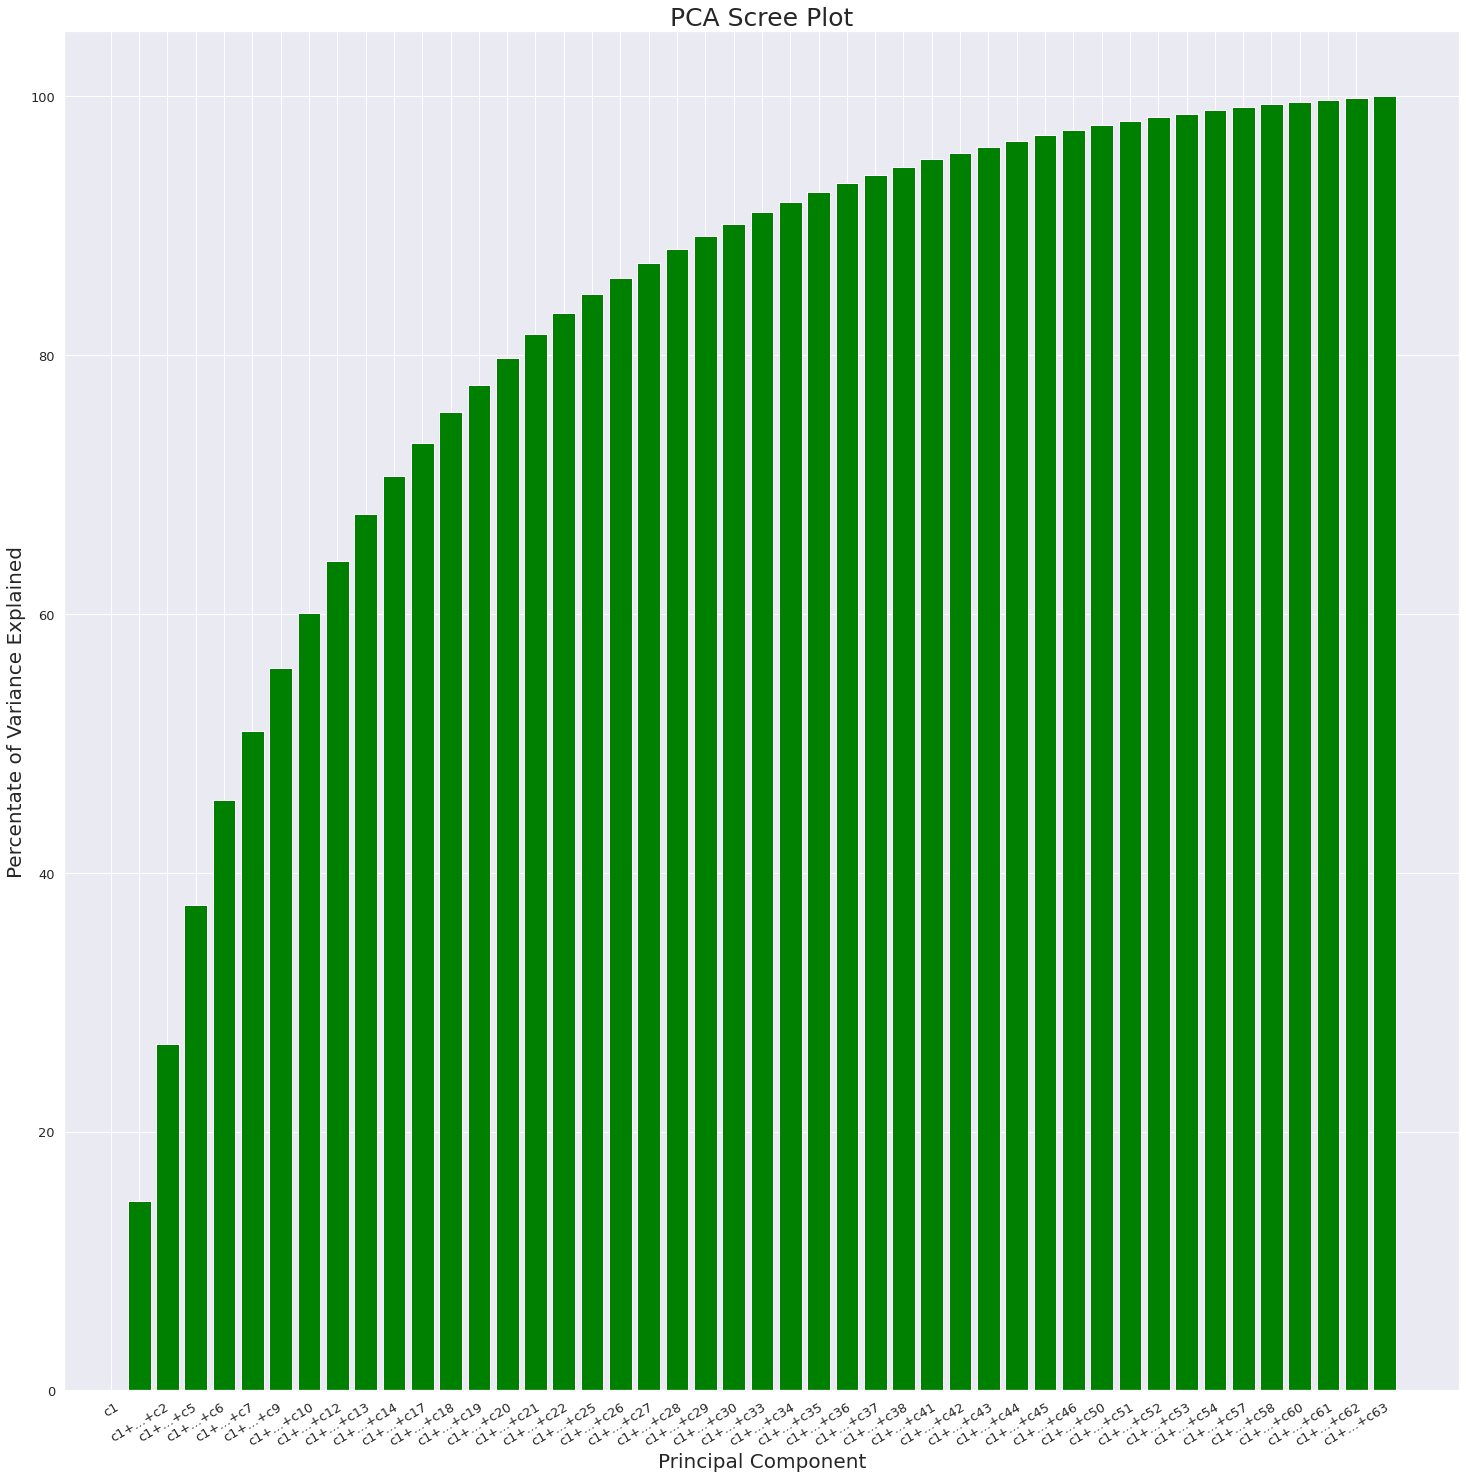

In [56]:
varianzas_acum = np.cumsum(varianzas)
columns_acum = [columns[0]]
#Etiquetas PCA acumulados
for i in range(1, len(columns)):
    columns_acum.append(columns[0] + '+...+' + columns[i])

#Grafico
plt.figure(figsize=(25,25))
plt.bar(x = range(1, len(columns) + 1),          #Eje x
        height = varianzas_acum,  #Valores
        color = 'green',
        tick_label = columns_acum)     #Etiquetas eje x

#Etiquetas
plt.tick_params(labelsize = 13)
plt.xticks(range(len(columns_acum)), columns_acum, rotation = 30)
plt.ylabel('Percentate of Variance Explained', **{'size':'20'})
plt.xlabel('Principal Component', **{'size':'20'})
plt.title('PCA Scree Plot', **{'size': '25'})
plt.show()

In [57]:
#Probando nuevamente el modelo
X_train, X_test, y_train, y_test =  train_test_split(data_X, y_train, test_size=0.18, random_state=42)
KNN_reduc = neighbors.KNeighborsClassifier()
KNN_reduc.fit(X_train,y_train)
metrics_KNN_reduc = summary_metrics(pd.DataFrame({'y':y_test, 'yhat':KNN_reduc.predict(X_test)}))
metrics_KNN_reduc

,accuracy,recall,precision,fscore
0,0.9877,0.9886,0.9899,0.9892


In [58]:
matrix_conf = confusion_matrix(list(y_test), list(KNN_reduc.predict(X_test)))
matrix_conf

array([[30,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 26,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 31,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 32,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 43,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 41,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0, 33,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 27,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 22,  0],
       [ 0,  0,  0,  0,  1,  1,  0,  0,  0, 35]])

In [59]:
print('Se acertó en:',sum(y_test == KNN_reduc.predict(X_test)) ,'datos.')

Se acertó en: 320 datos.


In [60]:
#Contaremos los falsos positivos y los falsos negativos
falses_pos_neg = count_fp_fn(matrix_conf)

print('Se tiene que los falsos positivos en este caso son:', falses_pos_neg[0])
print('Se tiene que los falsos negativos en este caso son:', falses_pos_neg[1])

Se tiene que los falsos positivos en este caso son: 2
Se tiene que los falsos negativos en este caso son: 2


Luego, es fácil notar que se obtuvieron los mismos resultados que cuando se tenian todos los datos.

### Ejercicio 6


__Visualizando Resultados:__ A continuación se provee código para comparar las etiquetas predichas vs las etiquetas reales del conjunto de _test_. 


In [61]:
def mostar_resultados(digits,model,nx=5, ny=5,label = "correctos"):
    """
    Muestra los resultados de las prediciones de un modelo 
    de clasificacion en particular. Se toman aleatoriamente los valores
    de los resultados.
    
    - label == 'correcto': retorna los valores en que el modelo acierta.
    - label == 'incorrecto': retorna los valores en que el modelo no acierta.

    
    Observacion: El modelo que recibe como argumento debe NO encontrarse
    'entrenado'.
    
    
    :param digits: dataset 'digits'
    :param model: modelo de sklearn
    :param nx: numero de filas (subplots)
    :param ny: numero de columnas (subplots)
    :param label: datos correctos o incorrectos
    :return: graficos matplotlib
    """
    
    
    X = digits.drop(columns = "target").values
    y = digits["target"].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) 
    model.fit(X_train, y_train) # ajustando el modelo
    y_pred = model.predict(X_test)

    # Mostrar los datos correctos
    if label == "correctos":
        mask = (y_pred == y_test)
        color = "green"
        
    # Mostrar los datos correctos
    elif label == "incorrectos":
        mask = (y_pred != y_test)
        color = "red"
    
    else:
        raise ValueError("Valor incorrecto")
    

    X_aux = X_test[mask]
    y_aux_true = y_test[mask]
    y_aux_pred = y_pred[mask]

    # We'll plot the first 100 examples, randomly choosen
    fig, ax = plt.subplots(nx, ny, figsize=(12,12))
    for i in range(nx):
        for j in range(ny):
            index = j + ny * i
            data  = X_aux[index, :].reshape(8,8)
            label_pred = str(int(y_aux_pred[index]))
            label_true = str(int(y_aux_true[index]))
            ax[i][j].imshow(data, interpolation = 'nearest', cmap = 'gray_r')
            ax[i][j].text(0, 0, label_pred, horizontalalignment = 'center', verticalalignment = 'center', fontsize = 10, color = color)
            ax[i][j].text(7, 0, label_true, horizontalalignment = 'center', verticalalignment = 'center', fontsize = 10, color = 'blue')
            ax[i][j].get_xaxis().set_visible(False)
            ax[i][j].get_yaxis().set_visible(False)
    plt.show()

**Pregunta**

* Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, grafique los resultados cuando:
 * el valor predicho y original son iguales
 * el valor predicho y original son distintos 


* Cuando el valor predicho y original son distintos ,  ¿Por qué ocurren estas fallas?

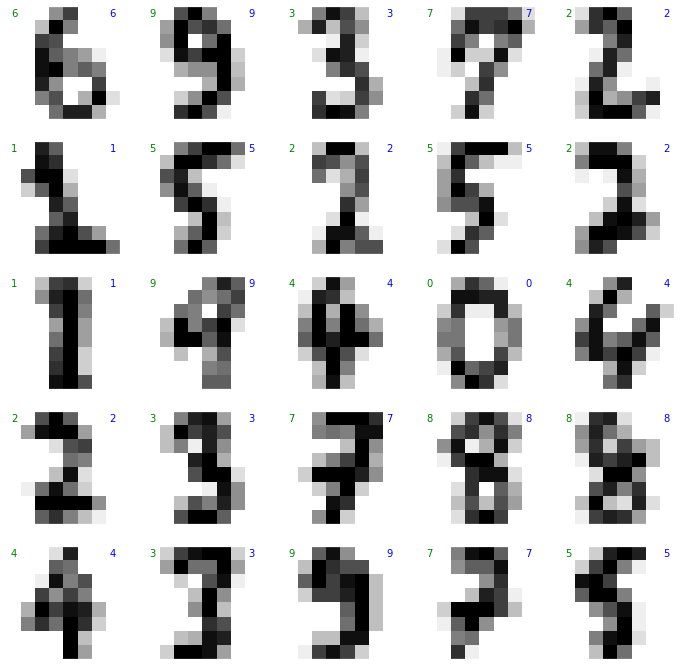

In [62]:
mostar_resultados(digits, neighbors.KNeighborsClassifier(), nx=5, ny=5,label = "correctos")

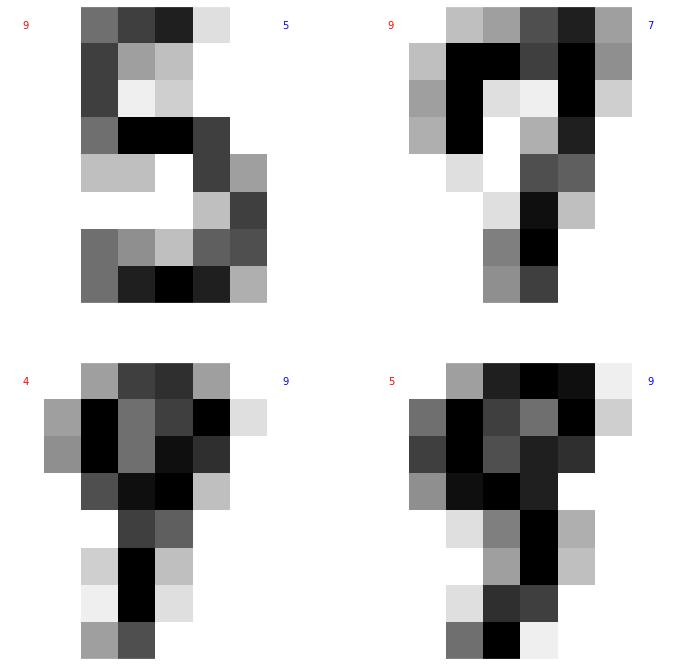

In [63]:
mostar_resultados(digits, neighbors.KNeighborsClassifier(), nx=2, ny=2,label = "incorrectos")

### Ejercicio 7
**Conclusiones**: Entrega tu veredicto, responde las preguntas iniciales, visualizaciones, trabajos futuros, dificultades, etc.

Estos problemas ocurren puesto que como se vio en algunos pasos anteriores, a pesar de que las metricas tenían valores cercanos a 1, nunca se logró obtener tal valor, lo mismo ocurría cuando se veía la matriz de confusión, es decir, a pesar de que el modelo presente valores que son muy buenos, estos nunca lograron presentar modelos con 0% de error.

Por otro lado, tambien se puede ver mientras se entrenaban y validaban modelos, se tenían buenos valores y también se presentaron colinealidades en algunos datos.

Para algún trabajo futuro, se podrían investigar mejores modelos para estos problemas, dado que algunas dificultades fueron la poca experiencia en trabajos de __ML__ y el poco conocimiento en la implementación de otros modelos, fuera de los aprendidos en clases.